In [123]:
# Load Packages
import sys
import sklearn
sys.path.append('../../')
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
import pandas as pd
import re
import xgboost as xgb
import os
import pickle
import re
import csv
import codecs
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from joblib import dump
from string import punctuation
from importlib import reload
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from sklearn.decomposition import PCA
from keras.models import Model
from sklearn.metrics import fbeta_score, make_scorer
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from internal.dataset_generator import page_info
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import sys
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
csv.field_size_limit(sys.maxsize)
#reload(sys)
#sys.setdefaultencoding('utf-8')


9223372036854775807

In [2]:
# one of the variants of merging two parts of dataset 
def get_matrix(matrix1, matrix2):
    matrix = np.zeros(matrix1.shape)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix1[i, j] == 0 and matrix2[i, j] == 0:
                matrix[i, j] = -1
            else:
                matrix[i, j] = (matrix1[i, j] * matrix2[i, j]) / (matrix1[i, j] + matrix2[i, j])
    return matrix

In [3]:
# Read Data
train = pd.read_csv('../dataset_generator/output/train.csv')
train = train[:6000]

In [4]:
# define tfidf vectorizer 
tfidf = TfidfVectorizer(analyzer = 'word',
                        stop_words = 'english',
                        lowercase = True,
                        max_features = 1000,
                        norm = 'l1')

In [5]:
# string that contains every text in train 
BagOfWords = pd.concat([train.iloc[:, 1], train.iloc[:, 3]], axis = 0)

In [6]:
tfidf.fit(BagOfWords)

TfidfVectorizer(max_features=1000, norm='l1', stop_words='english')

In [7]:
# saving TfidVectorizer for future using 
pickle.dump(tfidf, open('0003.pkl', "wb"))

In [8]:
train_q1_tfidf = tfidf.transform(train.iloc[:, 1])
train_q2_tfidf = tfidf.transform(train.iloc[:, 3])

In [ ]:
# merging two parts of dataset
# X = get_matrix(train_q1_tfidf, train_q2_tfidf)
# y = train.iloc[:, 4]

In [9]:
# merging two parts of dataset
X = abs(train_q1_tfidf - train_q2_tfidf)
y = train.iloc[:, 4]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensionality reduction 

In [68]:
params = {'reg_lambda': 5,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 2,
 'colsample_bytree': 1,
 'booster': 'gbtree'}
res_pca_components_mse = []
for i in [2, 10, 50, 100, 200]:
    X_train_pca = scipy.sparse.csr_matrix.toarray(X_train)
    X_test_pca = scipy.sparse.csr_matrix.toarray(X_test)
    pca = PCA(n_components=i)
    pca.fit(X_train_pca)
    X_train_pca = pca.transform(X_train_pca)
    X_test_pca = pca.transform(X_test_pca)
    xgb_reg = XGBRegressor(**params)
    xgb_reg.fit(X_train_pca, y_train)
    res_pca_components_mse.append(mean_squared_error(xgb_reg.predict(X_test_pca), y_test))

In [69]:
res_pca_components_mse

[0.8826539312929363,
 0.6311243517159022,
 0.5280963062636342,
 0.49306313368843413,
 0.46733265914189115]

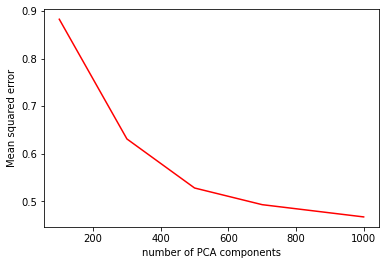

In [74]:
plt.plot(number, res_pca_components_mse, 'r')
plt.xlabel('number of PCA components')
plt.ylabel('Mean squared error')
plt.savefig('visualisation/number_pca_components_MSE.png')

# Xgboost Parameter Tuning Random search

In [11]:
parameters = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1, 0.01], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3]}

In [12]:
xgb_model = XGBRegressor()

In [ ]:
grid_obj_xgb = RandomizedSearchCV(xgb_model,parameters, cv=4, n_iter=10, scoring='neg_mean_squared_error',
                                  verbose=5,n_jobs=-1)
grid_obj_xgb.fit(X_train, y_train, verbose = 1)

In [14]:
grid_obj_xgb.best_params_

{'reg_lambda': 5,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 2,
 'colsample_bytree': 1,
 'booster': 'gbtree'}

# Cross Validation

In [90]:
# Training our model
params = {'reg_lambda': 5,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 2,
 'colsample_bytree': 1,
 'booster': 'gbtree'}

xgb_reg = XGBRegressor(**params)
#start_time = timer(None)
scores = cross_val_score(xgb_reg, X_train, y_train, scoring=make_scorer(mean_squared_error),  cv=4)
print(scores.mean(), scores)
#timer(start_time) 


0.44411870387214075 [0.43099311 0.4308277  0.44828783 0.46636618]


In [16]:
params = {'reg_lambda': 5,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 2,
 'colsample_bytree': 1,
 'booster': 'gbtree'}

xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=5, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [22]:
# saving model
xgb_reg.save_model("0003.model")

In [19]:
print(mean_squared_error(xgb_reg.predict(X_test), y_test))

0.39248551759440053


# Visualisation

In [18]:
# dependence on the number of samples

In [20]:
params = {'reg_lambda': 5,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 400,
 'min_child_weight': 10,
 'max_depth': 15,
 'learning_rate': 0.01,
 'gamma': 2,
 'colsample_bytree': 1,
 'booster': 'gbtree'}

In [40]:
res_number_samples_mse = []
number = [200, 500, 1000, 3000, 5000, 6000]
for i in number:
    xgb_reg = XGBRegressor(**params)
    xgb_reg.fit(X_train[:i], y_train[:i])
    res_number_samples_mse.append(mean_squared_error(xgb_reg.predict(X_test), y_test))

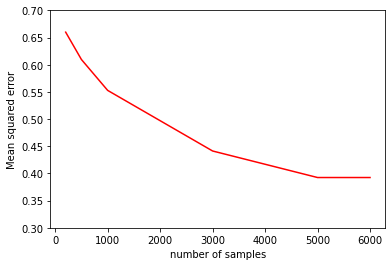

In [41]:
plt.plot(number, res, 'r')
plt.ylim([0.3, 0.7])
plt.xlabel('number of samples')
plt.ylabel('Mean squared error')
plt.savefig('visualisation/number_of_samples_MSE.png')

In [42]:
# dependence on the number of features

In [43]:
res_number_features_mse = []
number = [100, 300, 500, 700, 1000]
for i in number:
    xgb_reg = XGBRegressor(**params)
    xgb_reg.fit(X_train[:, :i], y_train)
    res_number_features_mse.append(mean_squared_error(xgb_reg.predict(X_test[:, :i]), y_test))

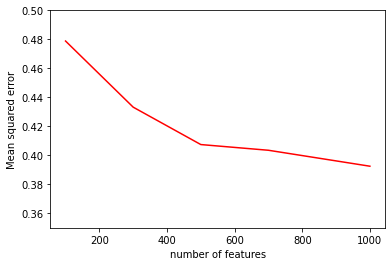

In [71]:

plt.plot(number, res_number_features_mse, 'r')
plt.ylim([0.35, 0.5])
plt.xlabel('number of features')
plt.ylabel('Mean squared error')
plt.savefig('visualisation/number_of_features_MSE.png')

In [ ]:
# the most important features
xgb_reg = XGBRegressor(**params)
xgb_reg.fit(X_train, y_train)

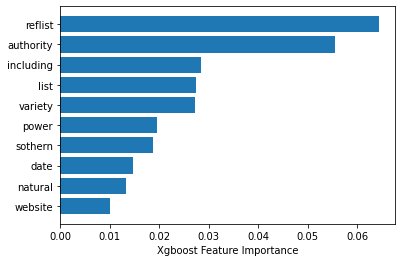

In [119]:
sorted_idx = xgb_reg.feature_importances_.argsort()
plt.barh(tfidf.get_feature_names_out()[sorted_idx][990:1000], xgb_reg.feature_importances_[sorted_idx][990:1000])
plt.xlabel("Xgboost Feature Importance")
plt.savefig('visualisation/the_most_important_features.png')

# Another algorithms

In [124]:
svm = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

# load model & predict

In [25]:
def predict(title1, title2):
    model_path = '0003.model'
    tfidf_path = "tfidf.pkl"
    bst = xgb.Booster({'nthread': 4})  # init model
    bst.load_model('0003.model')
    tfidf = pickle.load(open("tfidf.pkl",'rb'))
    #preprocessing
    predict_q1_tfidf = tfidf.transform(page_info.get(title1))
    predict_q2_tfidf = tfidf.transform(page_info.get(title2))
    X_pred = xgb.DMatrix(abs(predict_q1_tfidf - predict_q2_tfidf))
    predictions = bst.predict(X_pred)
    return predictions